# Kuramoto Model of the Uncinate Circuit

## Introduction

### Deep brain stimulation (DBS) and Psychiatric Illness

Brain disorders are thought to arise from dysfunctional signaling within complex brain networks. Deep brain stimulation (DBS) is the direct electrical stimulation of deep regions of the brain through surgically implanted electrodes. Despite the lack of any clear, quantitative model of brain signaling in diseases, particularly psychiatric diseases, the demonstrated efficacy of DBS is substantial.

### Oscillatory Activity in the Brain and Kuramoto Modeling

Electrical field potentials generated by large populations of sychronously firing neurons demonstrate strongly oscillatory components. Much of modern human-subject electrophysiology revolves around fourier-domain techniques for oscillatory power characterization.

Kuramoto networked oscillator models have been applied to neuroscience systems [1,2,3].

Deep brain stimulation (DBS) is direct stimulation of brain networks in order to treat neurological and psychiatric illnesses. Studying DBS effects directly in patients provides deeper insights into disease processes than animal models, but comes with major limitations. Computational models can bridge human subject electrophysiology with basic science by providing generative models for hypothesis testing approaches like [dynamic causal modeling]().

Here, we present one such generative model built on networked kuramoto oscillators.

## Kuramoto Basics

Phase oscillators form the basic unit of any Kuramoto model. Networked phase oscillators have richer dynamics and may be more appropriate for describing brain region interactions.

### Structure

Kuramoto globally-coupled oscillators are a good starting point for modeling oscillatory behavior in brain networks. In our case here, we will be doing topologically-coupled oscillator models, where the topology of the network is informed by structural priors on the network. Let's get started...

### Connectivity

Connectivity between kuramoto oscillators will be taken from the established imaging literature. Specifically, Diffusion Tensor Imaging (DTI) wi

In [26]:
%reset
%matplotlib inline
import networkx as nx
import numpy as nm
import scipy.signal as sig
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


We have to make sure we have the right *libraries* to do what we want to do. Key here is the networkx library. We will build around this library so that we have its in-built tools readily available to us. See my overview of **programming** to get a better idea of modular design, libraries, and the importance of respecting programming culture in scientific inquiry.

In [27]:
class KModel:
    G = nx.Graph()
    phase = nm.array([]) 
    states = nm.array([])
    timestep = 0    
    
    def __init__(self,nodes=6,edge_factor=0.2):
        self.G = nx.gnm_random_graph(nodes,nodes*nodes * edge_factor)
        
        #if states are oscillatory
        self.phase = nm.random.uniform(-nm.pi/2,nm.pi/2,[nodes,1])
        self.intrinsic_freq = nm.random.normal(0.5,0.1,[nodes,1])
        self.states = nm.sin(self.phase)        
        
    def give_graph(self):
        return self.G
        
    def give_states(self):
        return self.phase
        
    def state_blip(self,node):
        self.states[node] = -nm.pi/2
        
    def step_time(self):
        self.timestep += 1
        self.propagate_state()
                
    def propagate_state(self):
        self.phase -= self.intrinsic_freq + 1/6* nx.laplacian_matrix(self.G) * nm.sin(self.phase)
        self.phase = ( self.phase + nm.pi ) % (2 * nm.pi) - nm.pi        
        
        self.states = nm.hstack((self.states,nm.sin(self.phase)))

    def give_state_course(self):
        return self.states

Here, we've set up a simple KModel class. This will be the foundation of our Kuramoto Model. Classes are powerful entities that take functions, variables, and "information", package them into a self-contained object, and deliver to any other script a clean product that can plug into other code via a stereotyped, explicitly outlined **API**.

But, what can we actually **do** with this?

In [28]:

def main():
    n_nodes = 6
    UC = KModel(n_nodes,0.2)
    t = range(1,1000)
    #state_raster = numpy.zeros([n_nodes,1])

    for ts in t:
        #if ts % 10 == 0:
        #    UC.state_blip(3)
        UC.step_time()
        #state_raster = nm.hstack((state_raster,UC.give_states()))
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(131)
    nx.draw(UC.give_graph())
    
    ax = plt.subplot(132)
    ax.plot(UC.give_states())
    ax.set_title('State at the End of all nodes')

    ax = plt.subplot(133)
    ax.plot(UC.give_state_course().T)   
    plt.xlim((0,10))
    plt.xlabel('Time (seconds)')
    plt.ylabel('Phase Value')
    
    plt.show()
    
    #print(UC.give_states())

Our main function is heart of our program. The **python interpreter** looks through scripts in order to see what instructions it needs to run. But it's simple minded, so it always looks for, and starts at, a *main()* function. This is where we do what we want to do.

We make a call to KModel, and initialize it. This calls __init__ and we let the machinary we designed above do its thing.

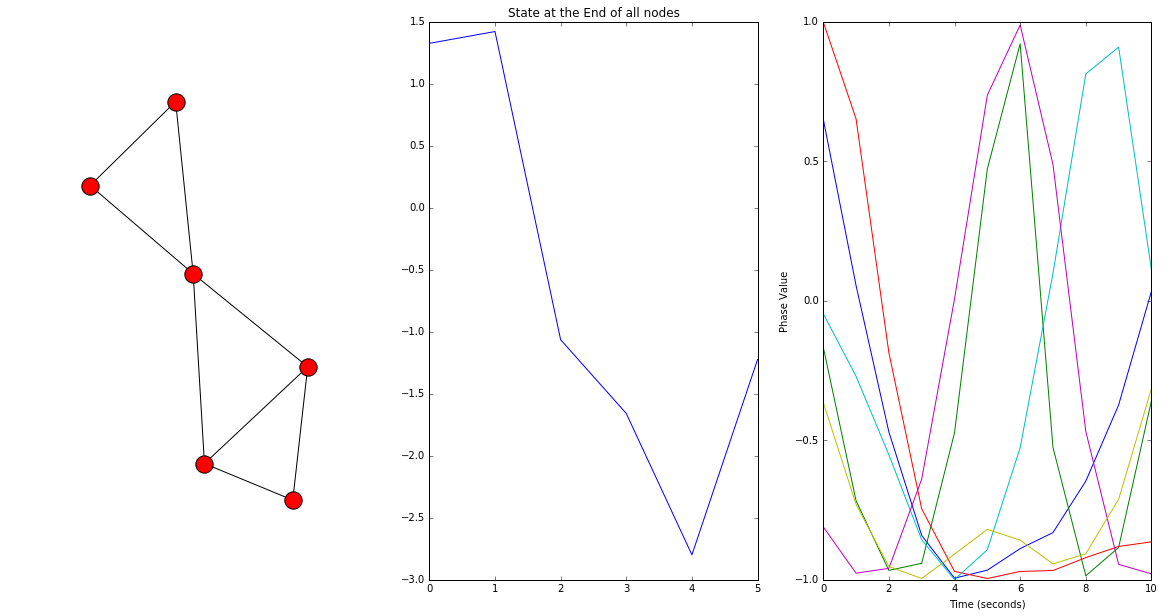

In [29]:
main()

## Bigger steps

The next step is to take this much further. We don't want to just do states that are coupled to each other. We want to test hypothesized mechanisms of action for DBS

### Clear Hypotheses

We're not quite clear on what happens in the signaling between nodes when we introduce DBS. Do we modulate the nodes specifically? Do we modulate the edges?

The literature suggests that the stimulation parameters we use for DBS maximally affect white matter tracts in the brain. This leads us to believe that we specifically modulate *edges* in our network

### Simplified Model

Let's work with a simplified model: a unilateral uncinate circuit model

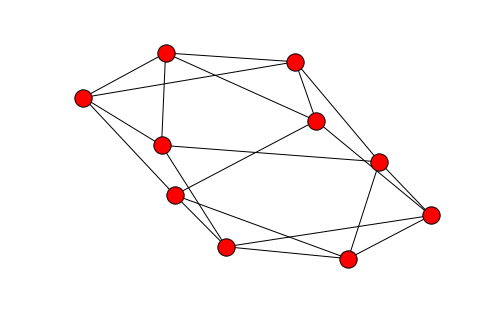

In [30]:
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_node(3)

G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(1,3)

G = nx.random_regular_graph(4,10)

plt.figure()
nx.draw(G)

plt.show()

#### Outline

In this model, each node is a scalar-valued *phase* $\phi$ that changes in time as a function of an intrinsic frequency $\omega$ and the phase difference between itself and its *neighbors*.

A networked kuramoto model looks like this at the *node dynamics* description

$
\begin{equation}
\dot{\phi_i} = \omega_i + \frac{1}{K} \sum\limits_{j \in N_i} sin(\phi_j - \phi_i)
\end{equation}
$

Key here is that the $sin()$ term ensures that the *consensus* state of the network is in $span(1)$

Instead, we want to do some richer things. Specifically, with the hypothesis that stimulation *breaks* an edge, we want to just remove j from the neighborhood of i if the edge (i,j) is in the edgeset. We're basically removing edges from the edgeset for stim


#### Matrix Formulation

$
\begin{equation}
\dot{\vec{\phi}} = \vec{\omega} + D sin( D^T \vec{\phi})
\end{equation}
$

$D$ is the incidence matrix (from $L = \Delta - A = DD^T$) and $D \in R^{NxE}$ where $N$ is the number of nodes, and $E$ is the number of edges.

As an aside: I'm *very* interested in what happens if stimulation actually **promotes** desynchronization. In that case, stimulation at an edge turns the interaction between nodes i and j into a $cos()$ relationship. Stay tuned for this below...

**This all looks cool** but...

Let's actually run these dynamics in a graph and see what happens to the state of each node over time. Since we're looking at phase synchrony, one way to visualize is to see what the variance of the state vector (network-level) is at every moment in time

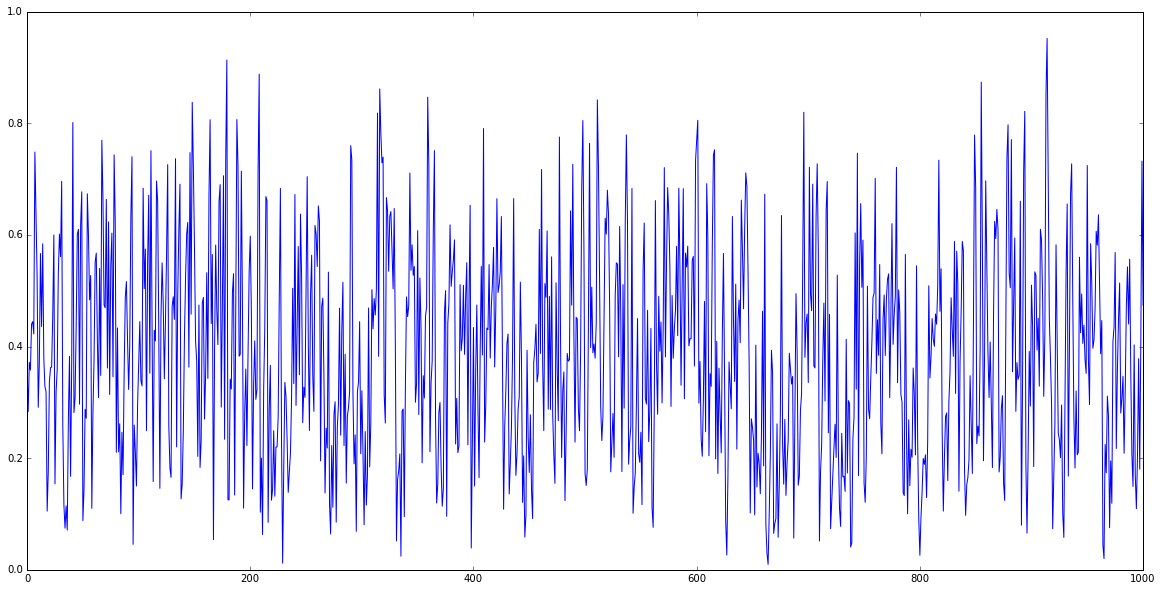

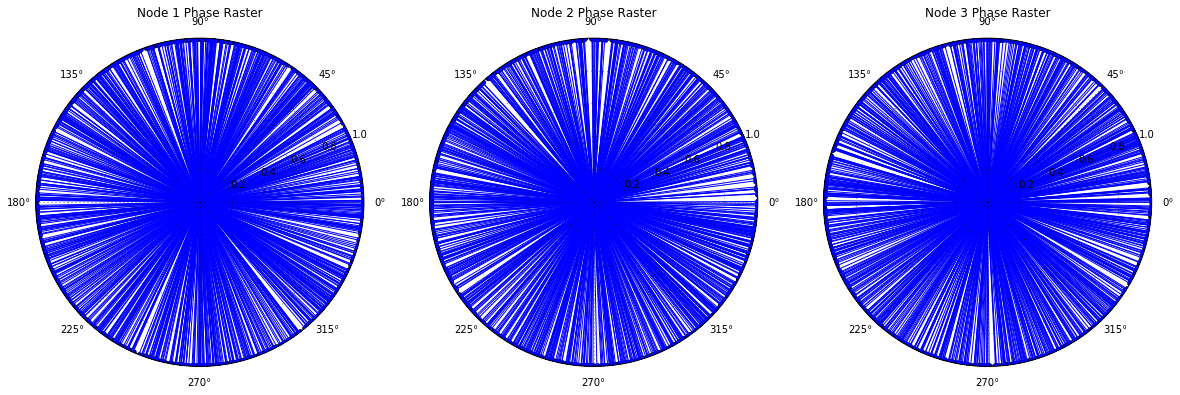

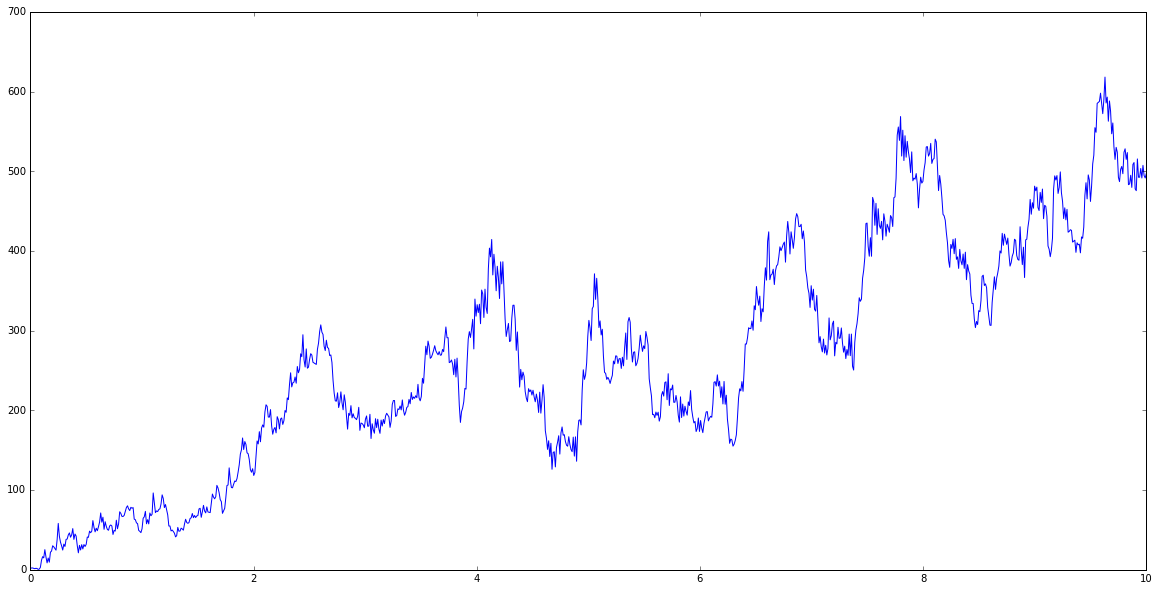

In [42]:
def run_KM(G,edge_func):
    D = (nx.incidence_matrix(G)).todense()
    state = []
    var_phase = []
    state = nm.matrix(nm.random.uniform(-nm.pi,nm.pi,size=(G.number_of_nodes(),1)))
    N = G.number_of_nodes()
    
    #Driving frequencies
    w = nm.random.uniform(0, 20,size=(G.number_of_nodes(),1))
    w = 10/10000
    
    timesteps = nm.linspace(0,10,1000)

    #If i want to move to dicts
    #from collections import defaultdict
    #state_d = defaultdict(list)

    we = 1
    for tt, ts in nm.ndenumerate(timesteps):
        curr_state = state[:,-1]
        #Cosine dynamics
        state_c = we*nm.dot(D,edge_func(nm.dot(D.T,curr_state)))
        #state_s = nm.dot(D,nm.sin(nm.dot(D.T,curr_state)))

        new_state = curr_state - state_c + w
        state = nm.hstack((state,new_state))

    rads = nm.ones(state.shape)

    plt.figure(figsize=(20,10))
    r_coher = 1/N * nm.sum(nm.exp(1j*state),0)
    plt.plot(nm.abs(r_coher.T))
    plt.show()
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(131,projection='polar')
    ax.stem(state[0,:].transpose(),rads[0,:].transpose())
    ax.set_title('Node 1 Phase Raster')
    ax = plt.subplot(132,projection='polar')
    ax.set_title('Node 2 Phase Raster')
    ax.stem(state[1,:].transpose(),rads[1,:].transpose())
    ax = plt.subplot(133,projection='polar')
    ax.set_title('Node 3 Phase Raster')
    ax.stem(state[2,:].transpose(),rads[2,:].transpose())
    ax.set_rmax(1)
    #ax.plot([0,nm.pi / 2, nm.pi],[1,1,1],color='r',linewidth=3)

    plt.show()


    var_phase = nm.squeeze(nm.var(state.T,1)).T
    #Plot variance in phase over time as well
    plt.figure(figsize=(20,10))
    plt.plot(timesteps,var_phase[0:-1,0])

run_KM(G,nm.sin)

Now let's run the same graph with $cos$ "edge dynamics" and see what the resulting phase difference between our elements is

In [ ]:
run_KM(G,nm.cos)

Now let's take out an edge and see the same plot (with cos dynamics)

In [ ]:
import copy

print('Old Edge Set: ' + str(G.edges()))
P = copy.deepcopy(G)
P = P.remove_edge(1,3)
print('New Edge Set: ' + str(G.edges()))  

run_KM(P,nm.cos)

## Harmonic Oscillators

Taking a step back, we want to expand beyond $sin()$ dynamics. I want to have a convex combination of $sin$ and $cos$. Let's work through the math...

$
... \sum{sin(\theta_j - \theta_i)}
$

$
...\sum{\frac{e^{j(\theta_j - \theta_i)} - e^{-j(\theta_j - \theta_i)}}{2j}}
$



### Back to connectivity

Returning to connectivity, our goal is to extent this model into the space informed by current studies into TRD DBS

Let's take a look at the tractmap

add tractmap

We have a network that looks like a base template. These include (a) edges that definitely connect node $x_i$ with $x_j$, and (b) edges that are thought to connect.


### Sin vs Cosine (or convex harmonic(?))

Looking at a "sine-edge" dynamic, we see that ensemble dynamics bring us to a stable fixed point. Cosine, however, brings us to a unstable fixed point, again at $span\{\bf{1}\}$, where the $\frac{\pi}{2}$ phase shift in the dynamics moves away from convergence/synchrony and moves instead to divergence and maximal phase offset (minimal entropy?)


### Bring in some data

First let's import some preprocessed data

In [ ]:
import pandas as pd
import numpy as np

fname = '/home/virati/MDD_Data/BR/905/Session_2015_09_14_Monday/Dbs905_2015_09_14_12_32_55__MR_0.txt'

raw_data = np.array(pd.read_csv(fname,sep=',',header=None))

LFP_data = raw_data[:,[0,2]]

#let's plot it

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(LFP_data[:,0])
plt.subplot(122)
plt.plot(LFP_data[:,1])

plt.show()

In [ ]:
#Plot the spectrogram of the data
plt.figure(figsize=(15,10))
P,F,b,im = plt.specgram(LFP_data[:,0],NFFT=512,noverlap=200,Fs=422)
plt.ylim((0,200))
#bandpass in theta
f_theta = np.logical_and(F < 14,F > 8)
P_theta = np.squeeze(np.sum(P[f_theta,:],0))

plt.figure(figsize=(15,10))
plt.plot(b,P_theta.T)
plt.show()

### Moving from Data to Model

We see that Theta ($\theta$ defined as oscillatory power within 8-14Hz) exhibits some dynamics in the acute stimulation case. There is also evidence that theta is critical for chronic changes in the SCC LFP